In [235]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import random

In [236]:
data = load_iris()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]

In [237]:
# define Dataset
class Dataset:
    def __init__(self, dataset, vector_machine):
      self.x, self.y = dataset
      self.y = np.array([vector_machine[_] for _ in self.y])
    def __getitem__(self, item): return self.x[item], self.y[item]
    def __len__(self): return len(self.y)
# Dataset

def dataset_visualize(dataset: Dataset):
  for x, y in dataset: print(f"{'-' * 16}\nx: {x}\ny: {y}")
# dataset_visualize

# init Datasets
hv_machine = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
trainset = Dataset((data.data, data.target), vector_machine=hv_machine)
testset = Dataset((data.data, data.target), vector_machine=hv_machine)
###dataset_visualize(trainset)

In [238]:
def sigmoid(x, e=2.7182): return 1 / (1 + e ** (-x))
def relu(x): return np.array([max(0, _) for _ in x])

In [239]:
def sgd(x, y, weight, act_func, lr):
    indications = act_func(np.dot(x, weight))
    weight -= (lr / x.shape[0]) * (indications - y)
# gdr

class Node:
    def __init__(self, n_inpt, n_oupt, autograd=False):
        self.weight = np.random.rand(n_inpt, n_oupt)
        self.autograd = autograd
        if self.autograd is True: self.grad = np.zeros(n_oupt)
    # __init__
    
    def train(self, dataset, iters: int, lr=0.01, act_func=relu):
        for _ in range(iters):
            for x, y in dataset:
                sgd(x, y, self.weight, act_func=act_func, lr=lr)
    # train
    
    def __call__(self, x):
        result = np.dot(x, self.weight)
        if self.autograd is True: self.grad = result.copy()
        return result
    # __call__
    
    def loss(self, dataset):
        x, y = dataset.x, dataset.y
        probability = np.dot(x, self.weight)
        loss = np.mean(np.exp(1 - probability) * y) + np.sum(np.exp(probability) * (1 - y))
        print(f"cost: {loss:.3f}")
    # loss
# ADALINE

class ANN:
    def __init__(self, autograd=False):
      self.autograd = autograd
    # __init__
    
    def __call__(self, x):
        result, first = 0, True
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if type(attr).__name__ == "Node":
                if first is True:
                    result = attr(x)
                    first = False
                # if
                else: result = attr(result)
        # for
        return result
    # forward
    
    def train(self, dataset, iters: int, lr=0.01, act_func=relu):
        # forward propagation
        if not self.autograd:
            for _ in range(iters):
                for x, y in dataset:
                    sgd(x, self.l1(x), self.l1.weight, act_func=act_func, lr=lr)
                    sgd(self.l1(x), y, self.l2.weight, act_func=act_func, lr=lr)
            return
        # if for for
        
        # backward propagation
        for _ in range(iters):
            for x, y in dataset:
                self.__call__(x)
                sgd(self.l1.grad, y, self.l2.weight, act_func=act_func, lr=lr)
                sgd(x, self.l1.grad, self.l1.weight, act_func=act_func, lr=lr)
        # for for
    # train
    
    def loss(self, dataset):
        x, y = dataset.x, dataset.y
        probability = self.__call__(x)
        loss = np.mean(np.exp(1 - probability) * y) + np.sum(np.exp(probability) * (1 - y))
        print(f"cost: {loss:.3f}")
    # loss
# ANN

In [240]:
class DNN(ANN):
    def __init__(self, n_inpt, n_output, autograd):
        super().__init__(autograd)
        self.l1 = Node(n_inpt, 10, autograd)
        self.l2 = Node(10, n_output)
    # __init__
# DNN

In [241]:
model = DNN(len(trainset.x[0]), len(trainset.y[0]), True)
model.loss(trainset)
model.train(trainset, iters=1000, lr=0.5)

cost: 469161981931786860964610048.000


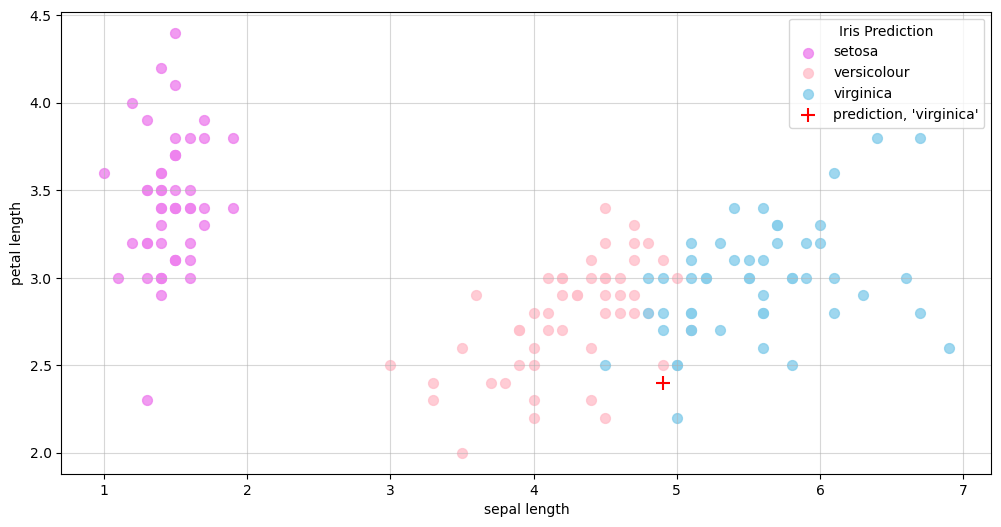

In [242]:
# init a testset
index = random.randrange(0, 150)
test_x, test_y = testset[index]

discrimination = lambda arr, value=1: np.where(arr == value)[0]

labels = ["setosa","versicolour","virginica"]
setosa = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if discrimination(trainset.y[_], 1) == 0])
versicolour = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if discrimination(trainset.y[_], 1) == 1])
virginica = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if discrimination(trainset.y[_], 1) == 2])
pred = model(test_x)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.set_xlabel('sepal length')
ax1.set_ylabel('petal length')
ax1.grid(True, alpha=0.5)

ax1.scatter(x=setosa[:, 2], y=setosa[:, 1], s=50, alpha=0.8, c="violet", label="setosa")
ax1.scatter(x=versicolour[:, 2], y=versicolour[:, 1], s=50, alpha=0.8, c="pink", label="versicolour")
ax1.scatter(x=virginica[:, 2], y=virginica[:, 1], s=50, alpha=0.8, c="skyblue", label="virginica")
ax1.scatter(x=test_x[0], y=test_x[1], s=100, alpha=1, c="r", marker="+", label=f"prediction, '{labels[np.argmax(pred)]}'")
ax1.legend(fontsize="10", loc="best", title="Iris Prediction")

In [243]:
model.loss(trainset)

cost: 69.584
